# 0. Import Modules and setup parameters

In [2]:
import cv2, os
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
print(os.getcwd())

C:\Users\Hai\Documents\UQ\UQ 2022 - Sixth Year\METR4911_ML_Python\MaskRCNN-Notebook


In [3]:
# coco_labels.txt, Labels for fruit/vegetable (6 labels) 
labels = {0: "Person", 51: "Banana", 52: "Apple", 54: "Orange", 55: "Broccoli", 56: "Carrot"}

# Color in BGR in CV2 not RGB, match color with object's color
colors = {"Person": (179,179,255), "Banana": (72,216,255), "Apple": (0,8,255), 
         "Carrot": (33,145,237), "Orange": (0,126,255), "Broccoli": (0,255,74)}

# Input Resize Image
img_width, img_height  = (640, 480)

#define plot size for all plots
plt.rcParams['figure.figsize'] = [6.4*1.75, 4.8*1.75]

# 1. Loading Mask RCNN

In [4]:
# Get file path of weights(.pb) and config (.pbtxt)
frozen_pb = os.path.join("cv_dnn", "mask_rcnn_inception_v2_coco_2018_01_28", "frozen_inference_graph.pb")
pb_txt = os.path.join("cv_dnn", "mask_rcnn_inception_v2_coco_2018_01_28.pbtxt")

print("Weights:", frozen_pb)
print("Config:",pb_txt)

# Load the weights and the config of Mask RCNN
net = cv2.dnn.readNetFromTensorflow(frozen_pb, pb_txt)

Weights: cv_dnn\mask_rcnn_inception_v2_coco_2018_01_28\frozen_inference_graph.pb
Config: cv_dnn\mask_rcnn_inception_v2_coco_2018_01_28.pbtxt


## 1.1 Object Detection and Mask Segmentation Function

In [5]:
""" 
    Modified Source code from: https://www.youtube.com/watch?v=8m8m4oWsp8M
    YouTube title: Instance Segmentation MASK R-CNN | with Python and Opencv
    YouTube Name: Pysource
    Date: May 18, 2021
"""
def object_detection_mask(img):
    """
    Passes the img into the MaskRCNN model to get the object detection boxes and its masks.
    
        Parameters:
                    img (numpy.ndarray): Original image

        Returns:
                    img (numpy.ndarray): Image with object detection boxes+labels drawn on top
                    black_image (numpy.ndarray): Image segmentation mask of each detected object
                    box_list (list: numpy.ndarray): List of detected boxes
                    mask_list (list: numpy.ndarray): List of masks of detected boxes
    """
    height, width, _ = img.shape  # (row, column)
    box_list = []
    mask_list = []
    
    ########################### Generate random colors and create black image ###########################
    black_image = np.zeros((height, width, 3), np.uint8)
    
    ########################### Detect objects ###########################
    blob = cv2.dnn.blobFromImage(img, swapRB=True)  # Get blob of input image
    net.setInput(blob)
    
    # boxes.shape (1,1,100,7),  mask.shape (100,90,15,15)
    boxes, masks = net.forward(["detection_out_final", "detection_masks"])  # Actual prediction (takes time)
    detection_count = boxes.shape[2]  # number of objects detected, 100 is the limit
    
    ############################ For each objects detected, draw box and mask ###########################
    for i in range(detection_count):
        # box [0,label,confidence,x1,y1,x2,y2] coods are normalised to 0-1 so multiply 
        #     the coods with image's width and height
        box = boxes[0, 0, i]
        class_id = int(box[1])  # Label/Class number, refer to coco_labels.txt
        score = box[2]          # Confidence percentage
        
        # If score below (is part of label) or not part of labels want to detect skip
        if class_id not in labels or score < 0.5:
            continue

        color = colors[labels[class_id]] # Color of object, defined in section 0
                
        ############################ Get Box Coordinates and Draw Box and Label ############################
        x = int(box[3] * width)    # Top left
        y = int(box[4] * height)   # Top left
        x2 = int(box[5] * width)   # Bottom right
        y2 = int(box[6] * height)  # Bottom right
        
        new_box = list(box.copy())
        new_box[3:] = (x, y, x2, y2)
        new_box[1] = labels[int(class_id)]
        box_list.append(new_box) # Get the box data
        
        # Draw rectangle box around detected object
        line_thickness = 2
        pad_x, pad_y = 2, 4
        cv2.rectangle(img, (x,y), (x2,y2), color, line_thickness) 
        
        # Draw Label's rectangle box and Add Text
        label_box_height = 20   # Change Height of Label Box
        label_box_width = 75    # Change Width of Label Box
        
        # Positions for box
        label_x = x - line_thickness // 2 
        label_y = y - label_box_height
        label_x2 = x + label_box_width
        label_y2 = y
        
        # Draw Box
        cv2.rectangle(img, (label_x,label_y), (label_x2,label_y2), color, cv2.FILLED)
        
        # Draw Text
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, labels[class_id], (x + pad_x, y - pad_y), font, 0.5, (0,0,0), 1, cv2.LINE_AA)
        
        ############################ Get the mask ############################
        roi = black_image[y: y2, x: x2]
        
        roi_height, roi_width, _ = roi.shape
        mask = masks[i, int(class_id)]  # mask.shape -> (15, 15)
        mask = cv2.resize(mask, (roi_width, roi_height))    # Resize from (15,15) to actual size
        
        # 0.5 is threshold of confidence score of each pixel? so over 0.5 becomes 255 and 0 otherwise
        _, mask = cv2.threshold(mask, 0.65, 255, cv2.THRESH_BINARY)
        
        ############################ Get Mask Coordinates ############################
        # Extract boundary of object
        contours, _ = cv2.findContours(np.array(mask, np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)         
        
        ############################ Draw and Fill Polygons ############################
        for cnt in contours:
            cv2.fillPoly(roi, [cnt], color)
    
    ############################ Display output image on computer ############################
    cv2.imshow("Frame", img)
    cv2.imshow("Black Image", black_image)
    
    return (img, black_image, box_list, mask_list)

# 2. Detect Static Image

In [6]:
# Load image
# img_file = "banana.d8fbcaf6-03f4-11ed-a1f3-95c0acd580f9.jpg"
# img_path = os.path.join("old_test_train_images_xml", "Fruit_Vegetable_15-July-22", "collectedimages", "banana", img_file)

img_file = "orange-finger-original.jpg"
img_path = os.path.join("WebCam_images", img_file)

print(img_path)

WebCam_images\orange-finger-original.jpg


Width: 640
Height: 480


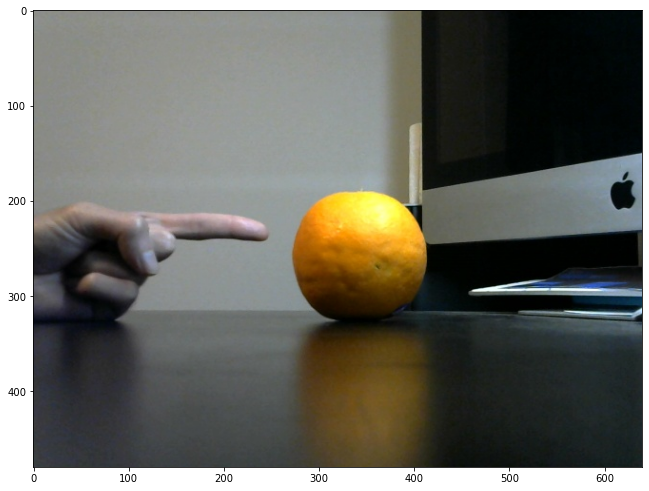

In [7]:
# Read image and resize image to (640, 480) or other dimensions
img = cv2.imread(img_path)
img = cv2.resize(img, (img_width,img_height), interpolation = cv2.INTER_AREA)
height, width, _ = img.shape

# 0 = open until any key is pressed, then close, any other number, in milliseconds, opens window in that duration
cv2.imshow("Image ({},{})".format(width, height), img)
cv2.waitKey(0)  
cv2.destroyAllWindows()

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Inline show image in notebook

print("Width:", width)
print("Height:", height)

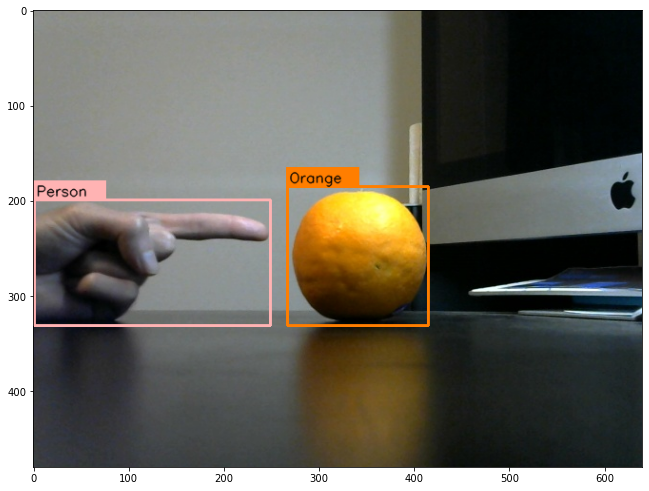

In [8]:
# For Static Image Only
object_detect_img, segmentation_img, box_list, mask_list = object_detection_mask(img)
cv2.waitKey(0)
cv2.destroyAllWindows() 

# Object Detection Box Image
plt.imshow(cv2.cvtColor(object_detect_img, cv2.COLOR_BGR2RGB))

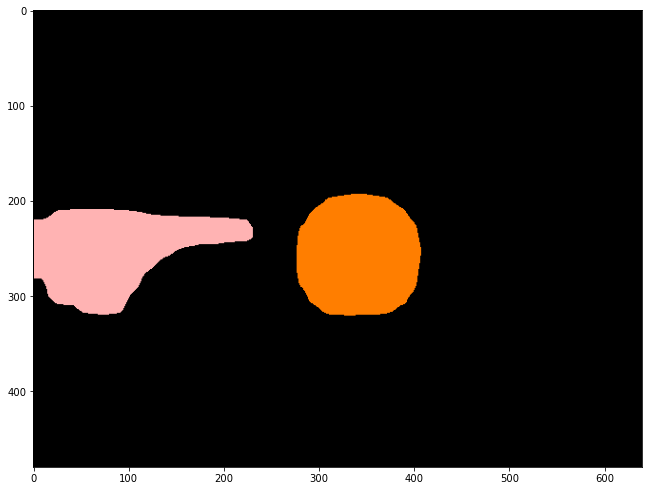

In [9]:
# Image Segementation Image
plt.imshow(cv2.cvtColor(segmentation_img, cv2.COLOR_BGR2RGB))

# 3. Real Time Video Object Detection and Segmentation

In [9]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    # object_detection_mask function returns -> (object_detect_img, segmentation_img)
    object_detect_img, segmentation_img = object_detection_mask(frame)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

In [ ]:
# Debuggin, or webcam still on when having errors
cap.release()
cv2.destroyAllWindows()

# 4. Get "area" of each object detected

In [32]:
# box [0,label,confidence,x1,y1,x2,y2] x1,y1,x2,y2 have been updated from function
window_x, window_y = 0, 0

for i in range(len(box_list)):
    # Display window of the detected object only
    box = box_list[i]
    x1,y1,x2,y2 = box[3:]
    object_img = img[y1:y2, x1:x2]
    window_name_od = "Object Detect: {}".format(box[1])
    cv2.imshow(window_name_od, object_img)
    cv2.moveWindow(window_name_od, window_x, window_y)
    
    # Display window of the image segmentaiton of detected object only
    segment_img = segmentation_img[y1:y2, x1:x2]
    window_name_segment = "Image Segmentation: {}".format(box[1])
    cv2.imshow(window_name_segment, segment_img)
    cv2.moveWindow(window_name_segment, window_x + (x2-x1), window_y)
      
    cv2.waitKey(0)  
    cv2.destroyAllWindows()

In [118]:
print(len(box_list))

2
